# Metadata annotation

This notebook demonstrates how to use pertpy to retrieve cell line metadata for perturbation annotation.

Advancements in multiplexing single-cell transcriptomics across experiments have revolutionized the high-throughput study of drug and genetic perturbations, enabling measuring hundreds of thousands of cells under unique conditions. Traditionally, institutes established comprehensive databases to understand these perturbation mechanisms on a large scale. Recently, significant progress in machine learning techniques has inspired the development of computational methods in modeling single-cell perturbation responses. To enhance the computational and statistical power of these approaches, we can integrate the data collected in the databases to develop, train, and test models.

For this purpose, pertpy provides tooling to allow more metadata to be easily fetched and perturbations to be annotated. This can help augment existing datasets with more datasets to increase sample sizes for training of deep learning models and add prior knowledge of data that cannot be seen initially. 

To facilitate this, we query a couple of databases, which can be categorized by the type of metadata:
- Cell line metadata： 
    - Cancer Dependency Map (DepMap) at Broad
    - Genomics of Drug Sensitivity in Cancer (GDSC)
- Genomic datasets:
    - DepMap at Broad: Gene expression data
    - DepMap at Sanger: Gene expression and protein intensity values
- Cell line x perturbation interactions:
    - Genomics of Drug Sensitivity in Cancer (GDSC): Drug sensitivity





In [1]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import random
import anndata as ad

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

Let's load the dataset from the original MIX-Seq paper (McFarland et al., 2020) and subset it by 5000 cells. Then we  create the metadata object.

In [2]:
adata = pt.dt.mcfarland_2020()
# subset the data
random.seed(8)
random_sample = random.sample(range(adata.n_obs), 5000)
adata = adata[random_sample, :]
#adata.write("adata_subset.h5ad")

pt_metadata = pt.tl.CellLineMetaData()

You can annotate cell line metadata by using the `annotate_cell_lines` function, which uses DepMap IDs as identifiers and adds DepMap metadata as new columns in the `obs` by default.

In [3]:
pt_metadata.annotate_cell_lines(adata)

AnnData object with n_obs × n_vars = 5000 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_i

We also provide a `lookup` object by calling `lookup()`, which can be used to query the database before annotating. Given a list of unique query IDs (e.g. cell line identifiers in the `adata.obs`) for the cells, the number of matched and not-matched identifiers in the metadata is returned.

In [4]:
lookup = pt_metadata.lookup()
lookup.available_bulk_rna_expression(query_id_list=adata.obs.cell_line.unique())
# pt_metadata.bulk_rna_sanger[pt_metadata.bulk_rna_sanger.index.isin(adata.obs.cell_line)]
# pt_metadata.annotate_bulk_rna_expression(adata, cell_line_source="sanger", query_id = "cell_line")

167 cell lines are not found in the metadata.

41 cell lines are found!

Note that cell line name is used as reference ID when annotating bulk RNA expression from Sanger. On the other hand, DepMap ID is used for bulk RNA expression data from Broad. This can be checked using `look.up.bulk_rna.{cell_line_source}.default_parameter`

In [5]:
lookup.bulk_rna.sanger.default_parameter

{'query_id': 'cell_line_name', 'cell_line_source': 'sanger'}

In [6]:
lookup.bulk_rna.broad.default_parameter

{'query_id': 'DepMap_ID', 'cell_line_source': 'broad'}

In [7]:
lookup.available_bulk_rna_expression(query_id_list=adata.obs.DepMap_ID.unique(), cell_line_source='broad')

1 cell lines are not found in the metadata.

207 cell lines are found!

We then fetch bulk RNA expression data which has more overlapping cell lines, here sourced from Broad institue. This data will be stored as a dataframe within `adata.obsm[bulk_rna_expression_{cell_line_source}]`

In [8]:
pt_metadata.annotate_bulk_rna_expression(adata, cell_line_source="broad", query_id = "DepMap_ID")

To annotate bulk RNA expression data from Broad Institue,  `DepMap_ID` is used as default reference and query 
indentifier if no `reference_id` is given.  Please make sure that `DepMap_ID` is available in the adata.obs.  
Alternatively, use the `annotate_cell_lines()` function to annotate the cell line first

There are 208 identifiers in `adata.obs`.

Following 1 identifiers can't be found in bulk RNA expression data, 

leading to the presence of NA values for their respective metadata. Please check again: 
- ACH-000047

AnnData object with n_obs × n_vars = 5000 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_i

We can also retrieve the cell line drug sensitivity data from GDSC database, which is saved as a single column `ln_ic50` in `obs`.

In [9]:
pt_metadata.annotate_from_gdsc(adata)

Following 92 identifiers can not be found in the drug response data for GDSC1,leading to the presence of NA values 
for their respective metadata. Please check it again:
- LU99
- Panc 04.03
- LMSU
- BICR 31
- L3.3
- UM-UC-1
- FTC-238
- 786-O
- Li-7
- KP4
- SNU-685
- HEC-1-B
- Malme-3M
- SNU-8
- SF-295
- DV-90
- SNU-1214
- Hs 852.T
- MIA PaCa-2
- COLO 668
- KNS-81
- NIH:OVCAR-3
- COV434
- NCI-H2126
- SNU-1077
- SNU-1076
- SW 900
- WM-266-4
- HCC-1195
- OVK18
- RERF-LC-Ad1
- PA-TU-8988S
- SNU-245
- TUHR4TKB
- CCF-STTG1
- HCC827
- S-117
- YD-10B
- HLF
- JHOM-1
- SH-10-TC
- Ishikawa (Heraklio) 02 ER-
- RMUG-S
- JHOC-5
- GP2d
- LOX IMVI
- Hey-A8
- RH-30
- OAW42
- NCI-H157-DM
- SNU-761
- MDA-MB-435S
- LNCaP clone FGC
- SW 480
- YD-38
- T3M-4
- SNU-C2A
- MCAS
- Hs 766T
- DMS 273
- LS1034
- PANC-1
- SNU-1105
- COLO 829
- HCT 116
- VM-CUB1
- Hep 3B2.1-7
- NCI-H322
- A-375
- SNU-1079
- Hs 294T
- ACC-MESO-1
- RERF-LC-Ad2
- TCC-PAN2
- SNU-840
- 22Rv1
- CJM
- BICR 6
- SNU-1041
- YD-15
- JHH-5
- SW579
- UO-31
- Sq-1
- SNU-410
- WM1799
- IGROV1
- 253J-BV
- KNS-60
- TEN
- HEC-1-A
- LUDLU-1

AnnData object with n_obs × n_vars = 5000 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_i

Great, we can now train a linear regression model  on bulk RNA-seq data to predict drug responses.

In [10]:
adata.obs[['cell_line_name', 'ln_ic50']]

,cell_line_name,ln_ic50
ATTTCACTCAATCCAG,NCI-H226,0.090283
CATAAGCAGACTCAAA,GAMG,3.458473
TGGGCTGGTTCAGCTA,ONS-76,1.921013
CCAATTTGTAGTGGCA,BICR 6,NaN
CTCGTCACAATCGAAA-1,NCI-H1299,NaN
...,...,...
TCACTATTCAGGAAGC,NCI-H226,NaN
CGATTGAGTCGTCTTC,OS-RC-2,4.736551
CGTTGGGGTGGTCCGT-1,COLO-680N,0.223879
GTGCGGTCATTTCACT-1,22Rv1,NaN


In [11]:
adata.obsm['bulk_rna_expression_broad']

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
ATTTCACTCAATCCAG,1.695994,0.0,6.496494,1.485427,3.890447,0.014355,1.899176,6.693905,3.499527,3.473787,...,0.000000,0.0,0.659925,0.000000,0.056584,0.389567,4.478972,0.000000,0.0,0.000000
CATAAGCAGACTCAAA,3.582556,0.0,6.778471,1.773996,3.735522,0.056584,0.163499,5.324091,5.289466,3.950468,...,0.000000,0.0,0.000000,0.000000,0.411426,0.495695,5.222264,0.000000,0.0,0.000000
TGGGCTGGTTCAGCTA,3.915521,0.0,6.789468,2.528571,3.578939,0.516015,7.615887,5.218006,4.895787,4.421560,...,0.000000,0.0,0.097611,0.042644,0.238787,0.757023,2.275007,0.042644,0.0,0.000000
CCAATTTGTAGTGGCA,3.650765,0.0,5.208283,1.310340,2.021480,0.454176,0.978196,4.507160,3.939227,2.500802,...,0.014355,0.0,0.000000,0.000000,0.014355,0.275007,3.779260,0.000000,0.0,0.000000
CTCGTCACAATCGAAA-1,2.859970,0.0,6.407183,2.060047,3.764474,0.042644,0.014355,6.307975,3.842979,3.960697,...,0.000000,0.0,0.028569,0.028569,0.214125,1.021480,3.234195,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCACTATTCAGGAAGC,1.695994,0.0,6.496494,1.485427,3.890447,0.014355,1.899176,6.693905,3.499527,3.473787,...,0.000000,0.0,0.659925,0.000000,0.056584,0.389567,4.478972,0.000000,0.0,0.000000
CGATTGAGTCGTCTTC,3.836934,0.0,7.361681,2.000000,3.513491,0.084064,5.318317,5.852748,3.238787,3.446256,...,0.000000,0.0,0.000000,0.056584,0.137504,0.641546,4.426265,0.000000,0.0,0.111031
CGTTGGGGTGGTCCGT-1,5.297558,0.0,6.513175,2.533563,3.054848,0.111031,2.565597,6.452859,4.785027,4.081510,...,0.028569,0.0,0.389567,0.014355,0.238787,1.709291,2.805292,0.333424,0.0,0.000000
GTGCGGTCATTTCACT-1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.0,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000


### Linear regression to predict drug sensitivity from bulk RNA-seq data

We observe that the data contains many missing values, so we subset the data where bulk RNA expression and viability value is not NA before performing linear regression.

In [12]:
viability = adata.obs.ln_ic50.values
not_na_viability = np.where(~np.isnan(viability))[0]
not_na_bulk = np.all(~np.isnan(adata.obsm['bulk_rna_expression_broad'].to_numpy()), axis=1)
not_na_bulk= np.where(not_na_bulk)[0]
not_na = np.intersect1d(not_na_bulk, not_na_viability)
not_na_bulk = adata.obsm['bulk_rna_expression_broad'].to_numpy()[not_na]
not_na_viability = viability[not_na]

In [13]:
# Split dataset to train and test data
train_num = int(len(not_na_viability) * 0.7)
train_index  = random.sample(range(len(not_na_viability)), train_num)
data_train = not_na_bulk[train_index]
label_train = not_na_viability[train_index]

test_index = [idx for idx in range(len(not_na_viability)) if idx not in train_index] 
data_test = not_na_bulk[test_index]
label_test = not_na_viability[test_index]

In [14]:
lr = LinearRegression()
lr.fit(data_train, label_train)
viability_predicted = lr.predict(data_test)

Mean squared error: 5.36
Coefficient of determination: 0.36


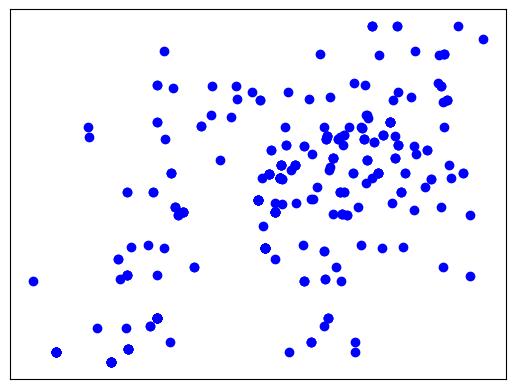

In [15]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(label_test, viability_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(label_test, viability_predicted))

# Visualisation
plt.scatter(label_test, viability_predicted, color="blue")
plt.xticks(())
plt.yticks(())
plt.show()

### Differential gene expression analysis

In [16]:
drug_response = pt_metadata.drug_response_gdsc1[pt_metadata.drug_response_gdsc1['cell_line_name'].isin(adata.obs.cell_line_name)]
drug_response = drug_response.pivot(index='cell_line_name', columns='drug_name', values='ln_ic50')
drug_response.head()

drug_name,(5Z)-7-Oxozeaenol,5-Fluorouracil,965-D2,993-D2,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,...,ZG-10,ZL049,ZL109,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL,torin2
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42-MG-BA,0.588826,2.220896,2.992956,4.755989,NaN,NaN,3.793761,2.390197,1.303087,7.562482,...,NaN,2.995327,-0.980930,1.339098,2.235509,5.494359,5.566457,3.082294,-1.651262,NaN
5637,1.626606,3.166983,4.410360,4.227483,NaN,NaN,3.847780,1.039981,1.127383,8.011505,...,NaN,2.053874,0.046212,0.556022,0.239659,5.144572,5.273391,2.519340,-2.889220,NaN
639-V,0.785227,4.210295,2.932099,4.028036,NaN,NaN,4.628202,2.099868,1.479390,7.448695,...,1.45309,4.385755,0.039382,1.779944,2.425340,5.144169,5.143294,1.978599,-2.467352,NaN
647-V,0.570678,3.228626,2.930507,3.106849,NaN,NaN,4.581358,1.754079,1.670076,7.547167,...,NaN,3.188942,-1.045608,3.044114,0.603523,5.756456,5.430844,2.733492,0.201503,NaN
769-P,0.612362,1.396611,3.010508,2.978909,NaN,NaN,3.855192,1.800764,1.943585,8.259149,...,NaN,3.162116,-0.425794,2.532378,-0.411142,5.441282,5.592060,1.830003,-0.026884,NaN


Before performing the clustering, we can impute the cell line sensitivity data with the mean IC50 value of this drug. Here we use `SimpleImputer` from sklearn package.

In [17]:
imputer = SimpleImputer(strategy='mean')
drug_response_imputed = imputer.fit_transform(drug_response.values)
drug_response_imputed

array([[ 0.588826  ,  2.220896  ,  2.992956  , ...,  3.082294  ,
        -1.651262  , -1.84439795],
       [ 1.626606  ,  3.166983  ,  4.41036   , ...,  2.51934   ,
        -2.88922   , -1.84439795],
       [ 0.785227  ,  4.210295  ,  2.932099  , ...,  1.978599  ,
        -2.467352  , -1.84439795],
       ...,
       [-0.905723  ,  2.297967  ,  2.880687  , ...,  0.83396   ,
         0.221525  , -1.84439795],
       [-0.182098  ,  2.916789  ,  2.907251  , ...,  1.384364  ,
        -0.046915  , -3.600791  ],
       [-2.328306  ,  3.911201  ,  1.454216  , ...,  3.015774  ,
        -0.115816  , -1.84439795]])

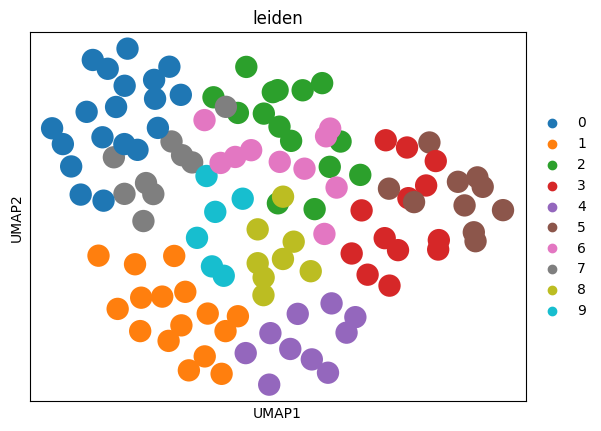

In [19]:
# Do clustering
sc.tl.pca(adata_drug_reponse)
sc.pp.neighbors(adata_drug_reponse)
sc.tl.umap(adata_drug_reponse)
sc.tl.leiden(adata_drug_reponse, resolution=2, key_added="leiden")
sc.pl.umap(adata_drug_reponse, color="leiden")

In [20]:
# Assign the leiden group to cell lines in the original adata
adata.obs = adata.obs.merge(adata_drug_reponse.obs[['leiden']], how = "left", 
                            left_on = "cell_line_name", right_index = True)
adata.obs.leiden = adata.obs.leiden.astype(str)
adata.obs['leiden'] = adata.obs['leiden'].replace("nan", 'unknown')
adata.obs.leiden = "cell line cluster " + adata.obs.leiden 
adata.obs.leiden = adata.obs.leiden.astype('category')
adata.obs

,DepMap_ID,cancer,cell_det_rate,cell_line,cell_quality,channel,disease,dose_unit,dose_value,doublet_CL1,...,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues,drug_name,ln_ic50,leiden
ATTTCACTCAATCCAG,ACH-000367,True,0.211837,NCIH226,normal,A,lung cancer,µM,0.1,NCIH226_LUNG,...,NaN,NaN,PT-hfcpvz,NaN,Pleural epithelioid mesothelioma,C45662,Indicated to have a TP53 p.Arg158Leu (c.473G>T...,Trametinib,0.090283,cell line cluster 6
CATAAGCAGACTCAAA,ACH-000098,True,0.131299,GAMG,normal,2,brain cancer,µM,0.5,GAMG_CENTRAL_NERVOUS_SYSTEM,...,NaN,NaN,PT-HmIANs,NaN,Glioblastoma,C3058,NaN,Afatinib,3.458473,cell line cluster 0
TGGGCTGGTTCAGCTA,ACH-000776,True,0.127041,ONS76,normal,2,brain cancer,µM,0.5,ONS76_CENTRAL_NERVOUS_SYSTEM,...,NaN,NaN,PT-DtdDWT,NaN,Medulloblastoma,C3222,NaN,Afatinib,1.921013,cell line cluster 7
CCAATTTGTAGTGGCA,ACH-000415,True,0.175474,BICR6,normal,2.0,head and neck cancer,µM,10.0,BICR6_UPPER_AERODIGESTIVE_TRACT,...,NaN,NaN,PT-Typnjw,NaN,Hypopharyngeal squamous cell carcinoma,C4043,NaN,NaN,NaN,cell line cluster unknown
CTCGTCACAATCGAAA-1,ACH-000510,True,0.137702,NCIH1299,normal,nan,lung cancer,nan,NaN,NCIH1299_LUNG,...,NaN,NaN,PT-7qWq2K,NaN,Lung large cell carcinoma,C4450,NaN,NaN,NaN,cell line cluster 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCACTATTCAGGAAGC,ACH-000367,True,0.143032,NCIH226,normal,1,lung cancer,µM,0.0,NCIH226_LUNG,...,NaN,NaN,PT-hfcpvz,NaN,Pleural epithelioid mesothelioma,C45662,Indicated to have a TP53 p.Arg158Leu (c.473G>T...,NaN,NaN,cell line cluster 6
CGATTGAGTCGTCTTC,ACH-000159,True,0.132034,OSRC2,normal,nan,kidney cancer,µM,0.1,OSRC2_KIDNEY,...,NaN,NaN,PT-T2g8EU,NaN,Clear cell renal cell carcinoma,C4033,NaN,Dabrafenib,4.736551,cell line cluster 2
CGTTGGGGTGGTCCGT-1,ACH-000717,True,0.126214,COLO680N,normal,nan,esophageal cancer,µM,0.1,COLO680N_OESOPHAGUS,...,NaN,NaN,PT-es34jp,NaN,Esophageal squamous cell carcinoma,C4024,NaN,Trametinib,0.223879,cell line cluster 3
GTGCGGTCATTTCACT-1,ACH-000956,True,0.093986,22RV1,normal,nan,prostate cancer,µM,0.1,22RV1_PROSTATE,...,NaN,NaN,PT-rqTCjv,NaN,Prostate carcinoma,C4863,NaN,NaN,NaN,cell line cluster unknown


In [21]:
# Find the sharing genes between McFarland dataset and the bulk RNA expression data
bulk_rna_gene_names = [gene_name.split(' (')[0] for gene_name in adata.obsm['bulk_rna_expression_broad'].columns.values]
bulk_rna_gene_names = np.array(bulk_rna_gene_names)
overlap_genes = np.intersect1d(bulk_rna_gene_names, adata.var.index.values)
overlap_gene_indices = np.where(np.isin(bulk_rna_gene_names, overlap_genes))[0]

In [22]:
# Sort coefficients of the overlapping genes in decreasing order
coeffcient = {'coefficients': lr.coef_[overlap_gene_indices], 'genes': bulk_rna_gene_names[overlap_gene_indices]}
coeffcient = pd.DataFrame(coeffcient)
coeffcient= coeffcient.reindex(coeffcient['coefficients'].abs().sort_values(ascending=False).index)
coeffcient = coeffcient.reset_index(drop=True)
coeffcient

,coefficients,genes
0,-1.083790e+13,AP2B1
1,1.051157e+13,WNT16
2,9.941727e+12,RHBDD2
3,9.656440e+12,THSD7A
4,8.907954e+12,ABHD5
...,...,...
20351,0.000000e+00,OR5L1
20352,0.000000e+00,AC010745.3
20353,0.000000e+00,LINC00583
20354,0.000000e+00,OR4C16


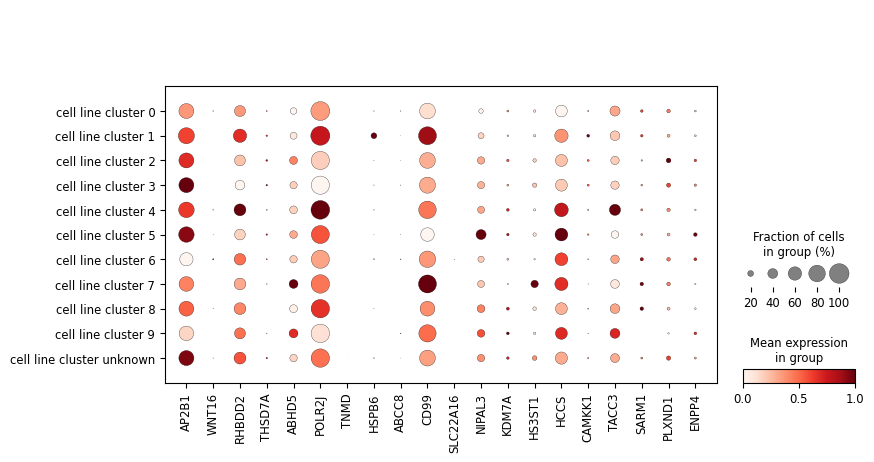

In [23]:
sc.pl.dotplot(adata, var_names = coeffcient.genes.values[0:20], groupby = 'leiden', standard_scale='var')

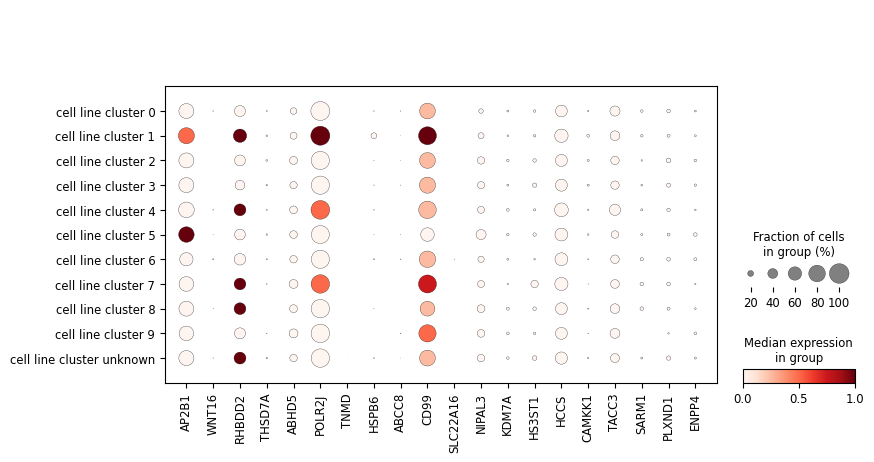

In [24]:
# Show median values
dp = sc.pl.dotplot(adata, var_names = coeffcient.genes.values[0:20], groupby = 'leiden', 
                   standard_scale='var', colorbar_title =  'Median expression\nin group', return_fig = True)
dp.dot_color_df = dp.obs_tidy.groupby(level=0).median().copy()
dp.dot_color_df = dp.dot_color_df.loc[dp.dot_size_df.index][dp.dot_size_df.columns]
dp.dot_color_df -= dp.dot_color_df.min(0)
dp.dot_color_df = (dp.dot_color_df / dp.dot_color_df.max(0)).fillna(0)

dp.make_figure()

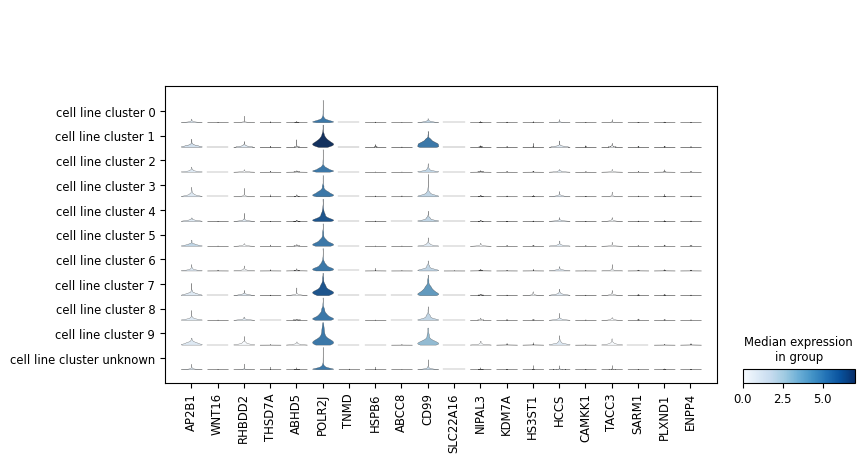

In [25]:
sc.pl.stacked_violin(adata, var_names = coeffcient.genes.values[0:20], groupby='leiden')

### Comparing the gene expression between base cell lines and broad cell lines

In [26]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [27]:
# Extract the baseline
adata.obs['DepMap_ID'] = adata.obs['DepMap_ID'].astype('category')
adata_control = adata[adata.obs.perturbation == 'control']
adata_control.obs.reset_index(drop=True, inplace=True)
adata_control

View of AnnData object with n_obs × n_vars = 780 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'pa

In [28]:
# Calculate the mean gene expression of cells in each cell line

# Baseline
base_line_expression = pd.DataFrame(columns=adata_control.var_names, index=adata_control.obs['DepMap_ID'].cat.categories)                                                                                                 
for cl in adata_control.obs.DepMap_ID.cat.categories: 
    base_line_expression.loc[cl] = adata_control[adata_control.obs['DepMap_ID'] == cl].X.mean(0)
base_line_expression.reset_index(inplace=True)
base_line_expression = pd.melt(base_line_expression, id_vars='index', var_name='Gene', value_name='Value')
base_line_expression.columns = ['Cell line', 'Gene', 'base']
base_line_expression.head()

# bulk RNA-seq data at Broad
broad_rna_gene = pt_metadata.bulk_rna_broad
broad_rna_gene.columns = [gene_name.split(' (')[0] for gene_name in broad_rna_gene.columns.values]
broad_rna_gene = broad_rna_gene.reset_index()
broad_rna_gene = pd.melt(broad_rna_gene, id_vars='index', var_name='Gene', value_name='Value')
broad_rna_gene.columns = ['Cell line', 'Gene', 'broad']

In [29]:
compare_cl_expr = base_line_expression.merge(broad_rna_gene, how = "inner")
compare_cl_expr.head()

,Cell line,Gene,base,broad
0,ACH-000001,MIR1302-10,0.0,0.0
1,ACH-000012,MIR1302-10,0.0,0.0
2,ACH-000015,MIR1302-10,0.0,0.0
3,ACH-000021,MIR1302-10,0.0,0.0
4,ACH-000022,MIR1302-10,0.0,0.0


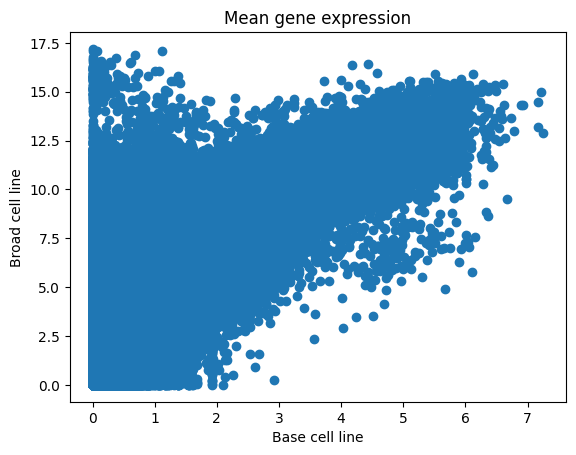

In [32]:
# Create scatter plot
plt.scatter(compare_cl_expr.base, compare_cl_expr.broad)

# Set labels and title
plt.xlabel('Base cell line')
plt.ylabel('Broad cell line')
plt.title('Mean gene expression')

# Display the plot
plt.show()